In [2]:
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt


In [ ]:
delta_time: float = 0.035

simulator_params: dict = {
    "dt": delta_time,
    "r": 0.10,
    "m": 3,
    "Jv": 5,
    "kt": 10e2,
    "kb": 10e-3,
    "ra": 10e-1,
    "ngb": 7,
    "psi": np.deg2rad([100, 100, 100]).transpose(),
    "L": np.array([0.2, 0.2, 0.2]).transpose(),
    "delta": np.deg2rad([60, 180, 60]).transpose(),
}
controller_params: dict = {
    "dt": delta_time,
}


class Simulator:
    def __init__(self, params: dict):
        self.params = params
        self.params["alpha"] = self.params["delta"] - self.param["psi"]

        self.MC = np.zeros(shape=(3, 3))
        self.MC[0, 0] = -np.cos(self.params["alpha"][0])
        self.MC[0, 1] = -np.sin(self.params["alpha"][0])
        self.MC[0, 2] = self.params["L"][0] * np.sin(self.params["psi"][0])
        self.MC[1, 0] = -np.cos(self.params["alpha"][1])
        self.MC[1, 1] = -np.sin(self.params["alpha"][1])
        self.MC[1, 2] = self.params["L"][1] * np.sin(self.params["psi"][1])
        self.MC[2, 0] = -np.cos(self.params["alpha"][2])
        self.MC[2, 1] = -np.sin(self.params["alpha"][2])
        self.MC[2, 2] = self.params["L"][2] * np.sin(self.params["psi"][2])

        self.MM = np.diag(
            [1 / self.params["m"], 1 / self.params["m"], 1 / self.params["Jv"]]
        )

        self.MA = (
            np.eye(3)
            * (1 / self.params["r"])
            * (self.params["kt"] * self.params["ngb"] / self.params["ra"])
        )
        self.MB = (
            np.eye(3)
            * (1 / self.params["r"])
            * (
                self.params["kt"]
                * self.params["kb"]
                * self.params["ngb"]
                * self.params["ngb"]
                / self.params["ra"]
            )
        )
        self.M1 = (1 / self.params["r"]) * self.MC @ self.MM @ self.MC.T @ self.MA
        self.M2 = (1 / self.params["r"]) * self.MC @ self.MM @ self.MC.T @ self.MB

    def dynamical_model(self,x,t,v):
        omega_dot = np.dot(self.M1,v) - np.dot(self.M2,x)
        return omega_dot

class Controller:
    def __init__(self, params: dict):
        self.params = params

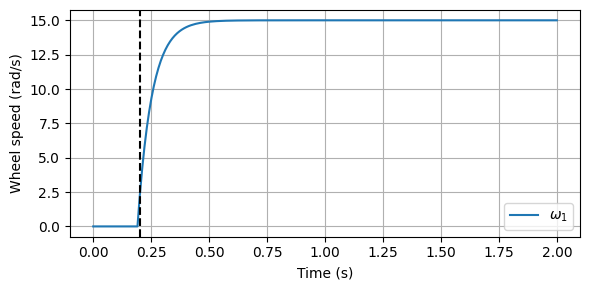

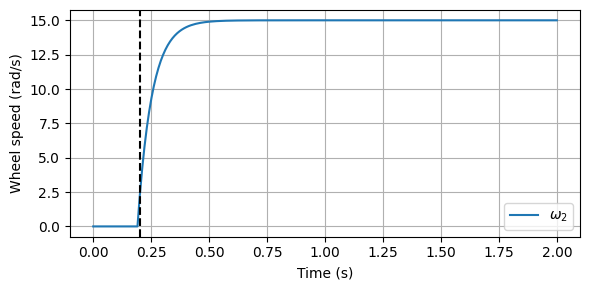

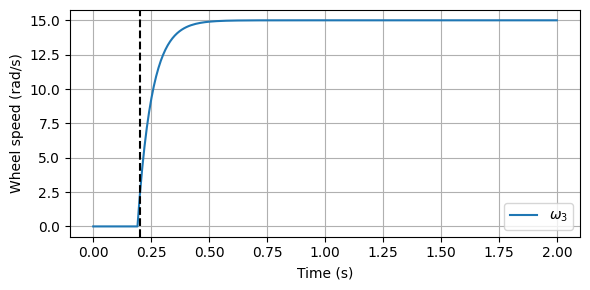

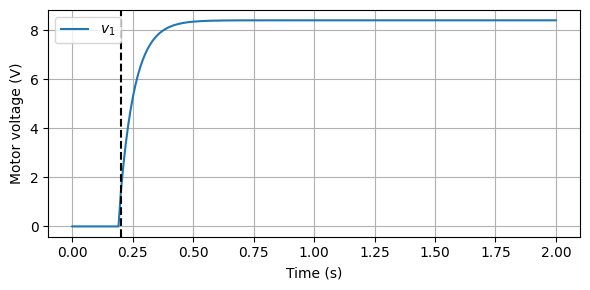

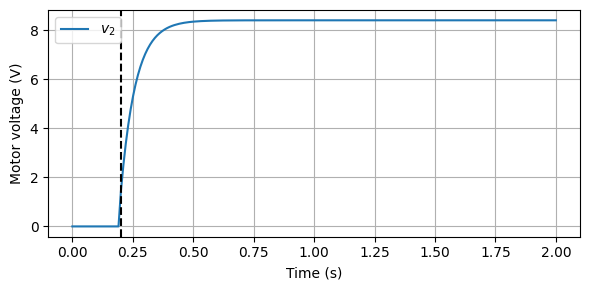

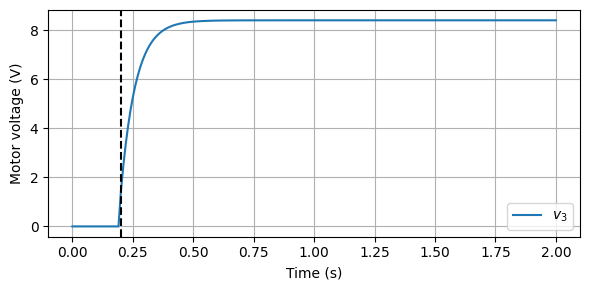

In [16]:
# Simulator + simple PI wheel-speed controller (cleaned & runnable)
import numpy as np
import matplotlib.pyplot as plt


# --- Helper: convert rpm/V to V/(rad/s) if needed (for kb)
def rpm_per_volt_to_kb(rpm_per_volt):
    # convert rpm/V -> rad/s per Volt
    rev_per_s_per_V = rpm_per_volt / 60.0
    rad_per_s_per_V = rev_per_s_per_V * 2 * np.pi
    # back-emf constant kb usually in V / (rad/s), so kb = 1 / (rad/s per V)
    return 1.0 / rad_per_s_per_V


params = {
    "dt": 0.01,
    "r": 0.05,  # wheel radius (m)
    "m": 2.0,  # robot mass (kg)
    "Jv": 0.125,  # rotational inertia (kg*m^2)
    "kt": 0.025,  # N*m / A
    "kb": rpm_per_volt_to_kb(460.0),  # V/(rad/s) approx, from 460 rpm/V spec
    "ra": 1.2,  # armature resistance (ohm)
    "ngb": 27.0,  # gearbox ratio (motor:wheel)
    "psi": np.deg2rad(np.array([90.0, 90.0, 90.0])),  # wheel traction angle psi_i
    "L": np.array([0.17, 0.17, 0.17]),  # distances Li
    "delta": np.deg2rad(
        np.array([0.0, 120.0, 240.0])
    ),  # wheel angular positions (robot fixed frame)
}

class Simulator:
    def __init__(self, params, omega0=np.zeros(3)):
        self.p = params.copy()
        self.p["alpha"] = self.p["delta"] - self.p["psi"]

        MC = np.zeros((3,3))
        for i in range(3):
            MC[i,0] = -np.cos(self.p["alpha"][i])
            MC[i,1] = -np.sin(self.p["alpha"][i])
            MC[i,2] = self.p["L"][i]*np.sin(self.p["psi"][i])
        self.MC = MC

        self.MM = np.diag([1/self.p["m"], 1/self.p["m"], 1/self.p["Jv"]])

        r, kt, kb, ra, ngb = (
            self.p["r"], self.p["kt"], self.p["kb"], self.p["ra"], self.p["ngb"]
        )

        self.MA = np.eye(3)*(kt*ngb/(ra*r))
        self.MB = np.eye(3)*(kt*kb*(ngb**2)/(ra*r))

        self.M1 = (1/r)*MC@self.MM@MC.T@self.MA
        self.M2 = (1/r)*MC@self.MM@MC.T@self.MB

        self.omega = omega0.copy()

    def step(self, v):
        omega_dot = self.M1 @ v - self.M2 @ self.omega
        self.omega += self.p["dt"] * omega_dot
        return self.omega.copy()

class GeneralMNRC:
    def __init__(self, f_func, g_func, Lambda_ref, zeta, tau, dt, n=3):
        self.f_func = f_func
        self.g_func = g_func
        self.Lambda = np.diag(Lambda_ref)  # For reference model (positive for stable poles)
        self.k = np.diag(2 * zeta / tau)   # Proportional gains
        self.k_I = np.diag(1 / (tau ** 2)) # Integral gains (for zeta=1)
        self.dt = dt
        self.y_m = np.zeros(n)
        self.e_I = np.zeros(n)

    def control(self, y, r):
        e = self.y_m - y
        dot_y_m = -self.Lambda @ (self.y_m - r)  # Reference model derivative
        f = self.f_func(y)
        g = self.g_func(y)
        inv_g = np.linalg.inv(g)
        u = inv_g @ (dot_y_m - f + self.k @ e + self.k_I @ self.e_I)
        
        # Update internal states (Euler integration)
        self.y_m += self.dt * dot_y_m
        self.e_I += self.dt * e
        
        return u
    
sim = Simulator(params, omega0=np.zeros(3))

# Define f and g for first level (wheel speeds)
f_func = lambda y: -sim.M2 @ y
g_func = lambda y: sim.M1

# Tuning (matching original Lambda=15, with zeta=1 for critical damping)
Lambda_ref = np.array([15.0, 15.0, 15.0])
zeta = np.array([1.0, 1.0, 1.0])
tau = 1.0 / Lambda_ref  # Time constants ~0.0667 s

ctrl = GeneralMNRC(f_func, g_func, Lambda_ref, zeta, tau, params["dt"])

T = 2.0
dt = params["dt"]
steps = int(T / dt)
t = np.linspace(0, T, steps)
omega_hist = np.zeros((3, steps))
v_hist = np.zeros((3, steps))

for k in range(steps):
    omega_r = np.array([15, 15, 15]) if t[k] > 0.2 else np.zeros(3)
    v = ctrl.control(y=sim.omega, r=omega_r)
    omega = sim.step(v)
    omega_hist[:, k] = omega
    v_hist[:, k] = v

for i in range(3):
    plt.figure(figsize=(6,3))
    plt.plot(t, omega_hist[i], label=rf"$\omega_{i+1}$")
    plt.axvline(0.2, ls="--", color="k")
    plt.xlabel("Time (s)")
    plt.ylabel("Wheel speed (rad/s)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

for i in range(3):
    plt.figure(figsize=(6,3))
    plt.plot(t, v_hist[i], label=rf"$v_{i+1}$")
    plt.axvline(0.2, ls="--", color="k")
    plt.xlabel("Time (s)")
    plt.ylabel("Motor voltage (V)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()